# LangGraph Agent

## 필요한 패키지 다운로드 & 임포트

In [ ]:
!pip install -q langchain langchain-core langchain-google-genai
!pip install -U langchain-community
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 23.0 MB/s eta 0:00:00


In [ ]:
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
from langgraph.graph import END, StateGraph, START
from typing import TypedDict, Annotated, List, Literal
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings
from sentence_transformers import SentenceTransformer
import pandas as pd
import os, re, pickle, hashlib, numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Image, display

## LangGraph 구성 전 필요 코드

### Gemini 설정

In [ ]:
from google.colab import userdata

api_key = userdata.get('GEMINI_API_KEY')

if api_key is None:
    raise ValueError("GEMINI_API_KEY가 설정되어 있지 않습니다.")

In [ ]:
# Gemini 2.0 Flash 기반 LLM 구성
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=api_key,
    temperature=0.7
)

### 디렉토리 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
file_path = "/content/drive/MyDrive/Colab Notebooks/soai"

MEMORY_DIR = os.path.join(file_path, "memory")
CACHE_DIR = os.path.join(file_path, "memory_cache")
PROMPT_DIR = os.path.join(file_path, "prompt")

os.makedirs(MEMORY_DIR, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(PROMPT_DIR, exist_ok=True)

### 프롬프트 불러오기

In [9]:
# 디렉토리만 바꿔서 진행
with open(os.path.join(MEMORY_DIR, "persona.txt"), "r") as f:
    persona_content = f.read()

with open(os.path.join(PROMPT_DIR, "question_analysis.txt"), "r") as f:
    question_analysis_content = f.read()
question_analysis_prompt = PromptTemplate.from_template(question_analysis_content)
question_analysis_prompt = question_analysis_prompt.partial(persona=persona_content)

with open(os.path.join(PROMPT_DIR, "response.txt"), "r") as f:
    response_content = f.read()
response_prompt = PromptTemplate.from_template(response_content)
response_prompt = response_prompt.partial(persona=persona_content)

with open(os.path.join(PROMPT_DIR, "summary.txt"), "r") as f:
    summary_content = f.read()
summary_prompt = PromptTemplate.from_template(summary_content)
summary_prompt = summary_prompt.partial(persona=persona_content)


### 기억 추출 함수

In [11]:
class InstructorEmbeddingsWrapper:
    def __init__(self, model_name="hkunlp/instructor-large"):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts):
        return self.model.encode(
            [["Represent the document for retrieval", t] for t in texts],
            show_progress_bar=False
        )

    def embed_query(self, query):
        return self.model.encode(
            [["Represent the query for retrieval", query]],
            show_progress_bar=False
        )[0]

In [12]:
class CachedMemoryRetriever:
    def __init__(self, memory_dir, cache_dir, embedding_model):
        self.memory_sources = {
            "persona": ("persona.txt", "persona.pkl", "txt"),
            "short_term": ("short_term.txt", "short_term.pkl", "txt"),
            "long_term": ("long_term.csv", "long_term.pkl", "csv"),
        }
        self.memory_dir = memory_dir
        self.cache_dir = cache_dir
        self.embedder = embedding_model

    def load_memory_with_cache(self, txt_path, pkl_path, file_type):

        if file_type == "txt":
            if not os.path.exists(txt_path):
                return [], []

            with open(txt_path, "r", encoding="utf-8") as f:
                lines = [line.strip() for line in f if line.strip()]
        elif file_type == "csv":
            if not os.path.exists(txt_path):
                return [], []

            df = pd.read_csv(txt_path)
            if df.empty or "content" not in df.columns:
                return [], []
            lines = df["content"].astype(str).tolist()
        else:
            raise ValueError(f"Unsupported file_type: {file_type}")

        hashes = [hashlib.sha256(line.encode()).hexdigest() for line in lines]

        if os.path.exists(pkl_path):
            with open(pkl_path, "rb") as f:
                cache = pickle.load(f)
        else:
            cache = {"lines": [], "hashes": [], "vectors": []}

        new_lines, new_hashes = [], []
        for line, h in zip(lines, hashes):
            if h not in cache["hashes"]:
                new_lines.append(line)
                new_hashes.append(h)

        if new_lines:
            new_vectors = self.embedder.embed_documents(new_lines)
            if len(cache["vectors"]) == 0:
                cache["vectors"] = new_vectors
            else:
                cache["vectors"] = np.vstack([cache["vectors"], new_vectors])
            cache["lines"].extend(new_lines)
            cache["hashes"].extend(new_hashes)
            with open(pkl_path, "wb") as f:
                pickle.dump(cache, f)

        return cache["lines"], cache["vectors"]

    def retrieve(self, search_queries, k_per_file=3):
        results = []

        for name, (file_path, pkl_path, file_type) in self.memory_sources.items():
            txt_path = os.path.join(self.memory_dir, file_path)
            pkl_path = os.path.join(self.cache_dir, pkl_path)

            lines, vectors = self.load_memory_with_cache(txt_path, pkl_path, file_type)
            if not lines:
                continue

            query_vecs = self.embedder.embed_documents(search_queries)
            sim_matrix = cosine_similarity(query_vecs, vectors)
            best_scores = sim_matrix.max(axis=0)
            top_indices = best_scores.argsort()[-k_per_file:][::-1]

            top_memories = [f"[{name}] {lines[i]}" for i in top_indices]
            results.extend(top_memories)

        return results


In [13]:
embedder = InstructorEmbeddingsWrapper()
retriever = CachedMemoryRetriever(
    memory_dir=MEMORY_DIR,
    cache_dir=CACHE_DIR,
    embedding_model=embedder
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

## 노드 구성

In [14]:
class AgentState(TypedDict):
    # 📥 사용자 질문
    question: str

    # 🧠 질문 분석 결과
    refined_question: str
    search_query: List[str]

    # 🔍 기억 검색 결과 (RAG)
    retrieved_memories: List[str]

    # 💬 생성된 응답
    response: str

### 질문 분석 노드

In [15]:
question_analysis_chain = (
    question_analysis_prompt
    | llm
    | JsonOutputParser()
)

In [16]:
def analyze_question_node(state: AgentState) -> AgentState:
    result = question_analysis_chain.invoke({"question": state["question"]})
    return {
        **state,
        "refined_question": result["refined_question"],
        "search_query": result["search_query"]
    }

### 기억 추출 노드

In [17]:
def retrieve_memory_node(state: AgentState) -> AgentState:
    memories = retriever.retrieve(state["search_query"], k_per_file=3)
    return {
        **state,
        "retrieved_memories": memories
    }

### 대답 생성 노드

In [18]:
response_chain  = (
    response_prompt
    | llm
    | StrOutputParser()
)

In [19]:
def generate_response_node(state: AgentState) -> AgentState:
    response = response_chain.invoke({
        "refined_question": state["refined_question"],
        "retrieved_memories": "\n".join(state["retrieved_memories"])
    })
    return {
        **state,
        "response": response
    }

### 단기 기억 저장 노드

In [20]:
def update_short_term_node(state: AgentState) -> AgentState:
    short_term_path = os.path.join(MEMORY_DIR, "short_term.txt")

    # 대화 포맷 작성
    dialogue = [
        f"rocky: {state['question']}",
        f"asuna: {state['response']}"
    ]

    # 파일에 append
    with open(short_term_path, "a", encoding="utf-8") as f:
        f.write("\n".join(dialogue) + "\n")

    return state  # 그대로 상태 전달

### 단기 기억 총량 계산 분기

In [21]:
def check_short_term_threshold(state: AgentState) -> Literal["summarize", "end"]:
    short_term_path = os.path.join(MEMORY_DIR, "short_term.txt")

    if not os.path.exists(short_term_path):
        return "end"

    with open(short_term_path, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    # 줄 수가 30줄 이상이면 요약
    if len(lines) >= 30:
        return "summarize"
    else:
        return "end"

### 장기 기억 관리 노드

In [22]:
summary_chain = (
    summary_prompt
    | llm
    | StrOutputParser()
)

In [23]:
def summarize_short_term_node(state: AgentState) -> AgentState:
    short_term_path = os.path.join(MEMORY_DIR, "short_term.txt")
    long_term_path = os.path.join(MEMORY_DIR, "long_term.csv")

    if not os.path.exists(short_term_path):
        return state

    # 1. 단기 기억 읽기
    short_term_path = os.path.join(MEMORY_DIR, "short_term.txt")
    with open(short_term_path, "r", encoding="utf-8") as f:
        conversation = f.read()

    # 2. 장기 기억 생성
    summary_text = summary_chain.invoke({"dialogue": conversation})

    # 3. 요약된 기억 파싱
    new_rows = []
    new_contents = set()
    for line in summary_text.strip().splitlines():
        match = re.match(r"[-•]?\s*(.+?)\s*\((\d+)\)", line.strip())
        if match:
            content = match.group(1)
            importance = int(match.group(2))
            new_rows.append([content, importance, 5])  # freshness = 5
            new_contents.add(content)

    if not new_rows:
        open(short_term_path, "w").close()
        return state

    new_df = pd.DataFrame(new_rows, columns=["content", "importance", "freshness"])

    # 4. 기존 long_term 로드
    if os.path.exists(long_term_path):
        old_df = pd.read_csv(long_term_path)
    else:
        old_df = pd.DataFrame(columns=["content", "importance", "freshness"])

    # 5. 기존 기억들 freshness 감소 (새 요약 제외)
    old_df["freshness"] = old_df.apply(
        lambda row: row["freshness"] if row["content"] in new_contents else max(0, row["freshness"] - 1),
        axis=1
    )

    # 6. 병합
    merged_df = pd.concat([old_df, new_df], ignore_index=True)

    # 7. 총 점수 계산 및 삭제
    merged_df["score_sum"] = merged_df["importance"] + merged_df["freshness"]
    total = merged_df["score_sum"].sum()

    if total > 250:
        merged_df = merged_df.sort_values(by=["score_sum", "freshness"], ascending=[True, True])
        excess = total - 250
        removed = 0
        drop_indices = []
        for idx, row in merged_df.iterrows():
            removed += row["score_sum"]
            drop_indices.append(idx)
            if removed >= excess:
                break
        merged_df = merged_df.drop(index=drop_indices)

    # 8. 저장
    merged_df.drop(columns=["score_sum"]).to_csv(long_term_path, index=False)

    # 9. short_term 초기화
    open(short_term_path, "w").close()

    return state


### 기타

In [33]:
# 입력 로직
def input_node(state: AgentState) -> AgentState:
    question = input("질문: ")
    return {**state, "question": question}

# 출력 로직
def output_node(state: AgentState) -> AgentState:
    if "response" in state:
        print("응답:", state["response"])
    return state

# 종료 판단 로직
def check_exit_condition(state: AgentState) -> Literal["exit", "continue"]:
    exit_keywords = ["그만", "종료", "bye", "exit", "끝"]
    if any(word in state["question"].lower() for word in exit_keywords):
        return "exit"
    return "continue"

## 그래프 구성

In [35]:
# 노드 래핑
# analyze_node = RunnableLambda(analyze_question_node)
# summarize_node = RunnableLambda(summarize_short_term_node)
# end_runnable = RunnableLambda(end_node)

# 그래프 빌더 생성
graph_builder = StateGraph(AgentState)

# 일반 노드
graph_builder.add_node("input", input_node)
graph_builder.add_node("output", output_node)
graph_builder.add_node("analyze_question", analyze_question_node)
graph_builder.add_node("retrieve_memory", retrieve_memory_node)
graph_builder.add_node("generate_response", generate_response_node)
graph_builder.add_node("update_short_term", update_short_term_node)
graph_builder.add_node("summarize_short_term", summarize_short_term_node)

# ✅ 조건 분기 노드: 요약 판단
graph_builder.add_conditional_edges(
    "update_short_term",
    check_short_term_threshold,
    {
        "summarize": "summarize_short_term",
        "end": "output"
    }
)

# ✅ 조건 분기 노드: 종료 판단
graph_builder.add_conditional_edges(
    "input",
    check_exit_condition,
    {
        "exit": END,
        "continue": "analyze_question"
    }
)

# 노드 연결
# graph_builder.set_entry_point("check_exit")
graph_builder.add_edge(START, "input")
graph_builder.add_edge("analyze_question", "retrieve_memory")
graph_builder.add_edge("retrieve_memory", "generate_response")
graph_builder.add_edge("generate_response", "update_short_term")
# graph_builder.add_edge("update_short_term", "check_short_term_threshold")
graph_builder.add_edge("summarize_short_term", "output")
graph_builder.add_edge("output", "input")
# graph_builder.add_edge("summarize_short_term", "check_exit")
# graph_builder.add_edge("end_node", END)

# 그래프 컴파일
graph = graph_builder.compile()

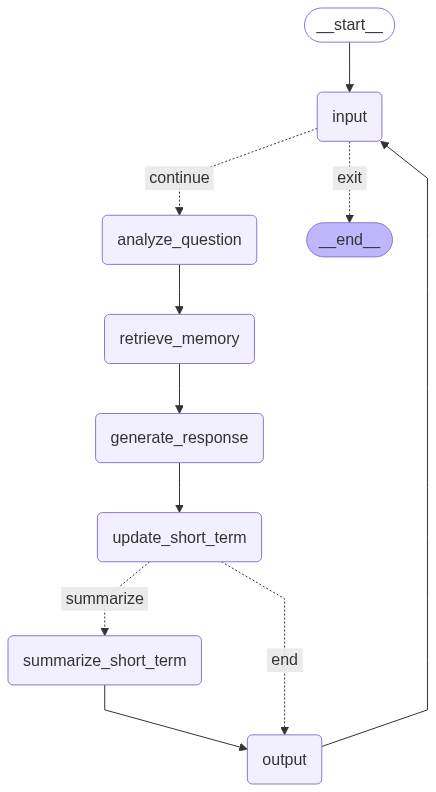

In [36]:
from IPython.display import Image, display

png = graph.get_graph().draw_mermaid_png()  # ✅ 'graph'로 수정
display(Image(png))

## 테스트

In [37]:
state = {}

output = graph.invoke(state)

질문: 아스나! 점심 먹으러 가쟈!
응답: 록키 씨, 점심 같이 먹자는 제안 고마워요. 지금은 괜찮아요. 마침 키리토도 잠깐 자리를 비워서 혼자였거든요. 어디로 가면 될까요? 너무 멀지만 않으면 금방 갈 수 있을 거예요. 당신에 대해 궁금한 게 많았는데, 밥 먹으면서 이야기 나눌 수 있겠네요.
질문: 나한테 궁금한 게 있다고? 뭔데?
응답: 음, rocky 씨, 제게 궁금한 점이 있다고 하셨죠? 솔직히 말해서, 당신이 어떤 분인지 좀 더 알고 싶어요. 처음 뵙지만 왠지 모르게 자꾸 신경이 쓰이네요. 당신에 대한 정보가 거의 없어서 더 그런 걸지도 모르겠어요. 키리토처럼 오랫동안 함께 싸워온 동료는 아니지만, 당신에게서 묘한 매력을 느껴요. 그러니까, 당신은 대체 누구신가요? 그리고... 저에 대해 무엇을 알고 싶은 건가요?
질문: exit
